In [153]:
%matplotlib inline


In [154]:
import matplotlib.pyplot as plt
import matplotlib
import os
from astropy.io import ascii, fits
import glob
from scipy.ndimage import gaussian_filter1d
from astropy.time import Time
import glob
import re
from astropy.table import Table
import astropy.table as at
import astropy
import numpy as np
import extinction

In [4]:
matplotlib.rcParams['figure.figsize']      = [15, 5]
matplotlib.rcParams['image.origin']        = 'lower'
matplotlib.rcParams['image.interpolation'] = 'none'
matplotlib.rcParams['image.cmap']          = 'inferno'
matplotlib.rcParams['image.aspect']        = 'auto'

In [7]:
spec_log = Table(names = ['phase', 'name', 'file'], dtype = ['i4', 'U8', 'U64'])
for folder in glob.glob('./reduced_spectra/*'):
    objname = folder.split('/')[2]
    f_list = glob.glob(folder+'/*')
#    obj_dict = {}
    for df in f_list:
        t = int(re.findall(r'd\d+', df)[0][1:])
#        obj_dict[t] = df
        spec_log.add_row([t, objname, df])
#    f_dict[objname] = obj_dict
spec_log.sort('phase')

z_dict = {'2010jl':0.0107,
          '2005ip':0.0072,
          '2020aekp':0.046,
          '2020nxt':0.023,
          '1998S':0.003, 
          '2011fe':0.0008,
          '2015G': 0.0045,
          '2021csp':0.083,
          '2017egm':0.030721,
          '2020fqv':0.007522}

type_dict = {'2010jl':'IIn',
          '2005ip':'IIn',
          '2020aekp':'Ia-CSM',
          '2020nxt':'Ibn',
          '1998S':'IIn', 
          '2011fe':'Ia',
          '2015G': 'Ibn',
          '2021csp':'Icn',
          '2017egm':'SLSN-I',
          '2020fqv':'Ia'}

In [ ]:
xcoords=[1238,1484  ,1548  ,1640  ,1660    ,1746   ,1907   ,2139   ,2323   ,2650           , 2795  ]
#xcoords=np.asarray(xcoords)*1.e-4
names=['N V' ,'N IV','C IV','He II','O III','N III','C III','N II]','C II]','Mg II + Fe II','Mg II']


In [16]:
from numpy import polyfit, poly1d
from scipy.integrate import simps
def calc_emflux(wav, flux, wav_up, wav_low):
    ind = (wav>wav_low)&(wav<wav_up)
    x = np.arange(len(wav))
    up_ind = max(x[ind])
    low_ind = min(x[ind])
    p = polyfit(np.array([wav[low_ind-1],wav[low_ind],wav[low_ind+1],wav[up_ind-1],wav[up_ind],wav[up_ind+1]]), 
               np.array([flux[low_ind-1],flux[low_ind],flux[low_ind+1],flux[up_ind-1],flux[up_ind],flux[up_ind+1]]),
               deg = 1)
    continuum = poly1d(p)
    emflux = simps(flux[ind]-continuum(wav[ind]), wav[ind])
    return emflux

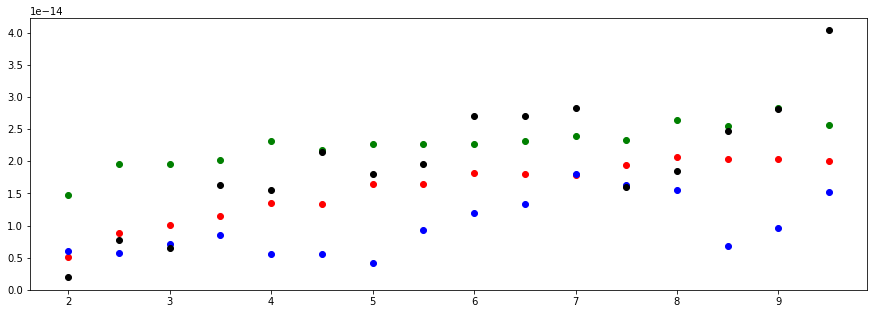

In [21]:
spec = fits.open('./reduced_spectra/2005ip/2005ip_d3042FUV_x1d.fits')
z = z_dict['2005ip']
ebv = 0.047
a_v = 3.1*ebv

for bound in np.arange(2., 10., 0.5):
    wav = spec[1].data['WAVELENGTH'][0]/(1+z)
    flux = spec[1].data['FLUX'][0]
    wav_up = 1242.8+bound
    wav_low = 1238.8-bound
    extinc = extinction.fitzpatrick99(np.array([wav_up,wav_low]), a_v, 3.1)[0]
    emflux = calc_emflux(wav, flux, wav_up, wav_low)*10**(extinc/2.5)
    plt.scatter(bound, emflux,color ='r')
    
for bound in np.arange(2., 10., 0.5):
    wav = spec[1].data['WAVELENGTH'][0]/(1+z)
    flux = spec[1].data['FLUX'][0]
    wav_up =  1486.5+bound
    wav_low = 1483.3-bound
    extinc = extinction.fitzpatrick99(np.array([wav_up,wav_low]), a_v, 3.1)[0]
    emflux = calc_emflux(wav, flux, wav_up, wav_low)*10**(extinc/2.5)*4.8/2.72
    plt.scatter(bound, emflux,color ='g')
    
for bound in np.arange(2., 10., 0.5):
    wav = spec[1].data['WAVELENGTH'][0]/(1+z)
    flux = spec[1].data['FLUX'][0]
    wav_up =  1550.7+bound
    wav_low = 1548.2-bound
    extinc = extinction.fitzpatrick99(np.array([wav_up,wav_low]), a_v, 3.1)[0]
    emflux = calc_emflux(wav, flux, wav_up, wav_low)*10**(extinc/2.5)*4.8/1.14
    plt.scatter(bound, emflux,color ='b')
    
for bound in np.arange(2., 10., 0.5):
    wav = spec[1].data['WAVELENGTH'][0]/(1+z)
    flux = spec[1].data['FLUX'][0]
    wav_up = 1640.4+bound
    wav_low = 1640.4-bound
    extinc = extinction.fitzpatrick99(np.array([wav_up,wav_low]), a_v, 3.1)[0]
    emflux = calc_emflux(wav, flux, wav_up, wav_low)*10**(extinc/2.5)*4.8/0.88
    plt.scatter(bound, emflux,color ='k')

In [263]:
def calc_emflux(wav, flux, wav_up, wav_low, continuum, cont_bound = 1):
    ind = (wav>wav_low)&(wav<wav_up)
#    x = np.arange(len(wav))
#    up_ind = max(x[ind])
#    low_ind = min(x[ind])
#    p = polyfit(np.append(wav[low_ind-cont_bound:low_ind+cont_bound+1],wav[up_ind-cont_bound:up_ind+1+cont_bound]), 
#                   np.append(flux[low_ind-cont_bound:low_ind+cont_bound+1],flux[up_ind-cont_bound:up_ind+1+cont_bound]),
#                   deg = 1)
#    continuum = poly1d(p)
    emflux = simps(flux[ind]-continuum(wav[ind]), wav[ind])
    return emflux

def plot_region(ax, wav, flux, linewaves, error = None, linename = None, int_bound = 6, bound = 6, 
                xlim =5, ylim = 5e-15,cont_bound = 3, v_shift = 0.):
    
    wav_up =  max(np.array(linewaves)*(1+v_shift/3e5))+bound
    wav_low = min(np.array(linewaves)*(1+v_shift/3e5))-bound
    ind = (wav>wav_low)&(wav<wav_up)
    x = np.arange(len(wav))
    up_ind = max(x[ind])
    low_ind = min(x[ind])
    p = polyfit(np.append(wav[low_ind-cont_bound:low_ind+cont_bound+1],
                          wav[up_ind-cont_bound:up_ind+1+cont_bound]), 
                   np.append(flux[low_ind-cont_bound:low_ind+cont_bound+1],
                             flux[up_ind-cont_bound:up_ind+1+cont_bound]),
                   deg = 1)
    continuum = poly1d(p)
    x = np.arange(wav_low-1, wav_up+1)
    ax.text(wav_up, ylim/5*4,linename)
    ax.plot(x,continuum(x))
    ax.fill_between(wav[low_ind-cont_bound:low_ind+cont_bound+1], np.ones(2*cont_bound+1), -np.ones(2*cont_bound+1),
                   color = 'grey', alpha = 0.2)
    ax.fill_between(wav[up_ind-cont_bound:up_ind+1+cont_bound], np.ones(2*cont_bound+1), -np.ones(2*cont_bound+1),
                   color = 'grey', alpha = 0.2)

    ax.set_xlim(wav_low-xlim, wav_up+xlim)

    wav_up =  max(np.array(linewaves)*(1+v_shift/3e5))+int_bound
    wav_low = min(np.array(linewaves)*(1+v_shift/3e5))-int_bound
    int_ind = (wav>wav_low)&(wav<wav_up)
    ax.fill_between(wav[int_ind], np.ones(sum(int_ind)), -np.ones(sum(int_ind)),
                   color = 'green', alpha = 0.2)
    ax.plot(wav, flux, marker = 'o')
    for line in linewaves:
        ax.axvline(line*(1+v_shift/3e5), linestyle = ':')
    extinc = extinction.fitzpatrick99(np.array([wav_up,wav_low]), a_v, 3.1)[0]
    emflux = calc_emflux(wav, flux, wav_up, wav_low, continuum, cont_bound = cont_bound)*10**(extinc/2.5)
    ax.text(wav_up-3, ylim/10*7,'line flux = {:.2f}'.format(emflux*1e15)+r' $\times 10^{-15}$ ')
    if error is not None:
#        error = abs(error)
        emerror = np.sqrt(simps(error[int_ind]**2, 
                                wav[int_ind])*((max(wav[int_ind])-min(wav[int_ind]))/len(wav[int_ind])))
        ax.text(wav_up-3, ylim/10*6,'error = {:.2f}'.format(emerror*1e15)+r' $\times 10^{-15}$')
    else:
        emerror = 0
    if v_shift !=0.:
        ax.text(wav_up-3, ylim/10*5,'v = {:.2f}'.format(v_shift)+' km/s')

    ax.set_ylim(-ylim/10, ylim)
    return emflux, emerror

In [269]:
import astropy.table as at
init_row = ['SNname',0,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.]
fuv_lineflux = at.Table([['SNnamewhateverlong'],[0],[0.],[0.],[0.],[0.],[0.],[0.],[0.],[0.],[0.],[0.],[0.],[0.],[0.],[0.],[0.],[0.]],
                       names=('obj', 'phase', 'NV1238', 'd_NV1238', 'OI1305', 'd_OI1305', 'CII1335', 'd_CII1335',
                             'SiIV1398', 'd_SiIV1398', 'NIV1483','d_NIV1483','CIV1548','d_CIV1548',
                             'HeII1640', 'd_HeII1640', 'OIII1660','d_OIII1660'))


In [460]:
init_row = ['SNname',0,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.]
nuv_lineflux = at.Table([['SNnamewhateverlong'],[0],[0.],[0.],[0.],[0.],[0.],[0.],[0.],[0.],[0.],[0.],[0.],[0.]],
                       names=('obj', 'phase', 'NIII1746', 'd_NIII1746', 'CIII1907', 'd_CIII1907', 
                              'NII2139', 'd_NII2139', 'CII2323','d_CII2323','MgIIFeII2650','d_MgIIFeII2650',
                             'MgII2795', 'd_MgII2795'))


In [484]:
fuv_lineflux

obj,phase,NV1238,d_NV1238,OI1305,d_OI1305,CII1335,d_CII1335,SiIV1398,d_SiIV1398,NIV1483,d_NIV1483,CIV1548,d_CIV1548,HeII1640,d_HeII1640,OIII1660,d_OIII1660
str18,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2005ip,3042,2.0994069355034187e-14,7.273114682125263e-16,8.919201063508329e-17,2.1943086709763512e-16,3.7228783254299403e-16,2.447755739599876e-16,9.372825455782288e-16,2.9374493713723114e-16,1.3756847746835463e-14,7.403704608260501e-16,3.661204510278833e-15,6.002623188510576e-16,4.9275582634206565e-15,8.118862518103928e-16,1.4193176760802805e-15,7.305079927865169e-16
2005ip,4337,1.61149987769622e-15,4.471551710861727e-16,1.6779751939133654e-15,2.9848507399139483e-16,-8.775918610047217e-16,3.2562746631194805e-16,-1.3213487703602165e-15,3.797591856087624e-16,2.7365330877217367e-15,4.915138814889684e-16,6.295963994204363e-16,4.607216647560199e-16,1.7344927844766565e-15,6.326266975934887e-16,2.5221220828584766e-16,7.334969367016613e-16
2021csp,8,2.3821002676901454e-14,4.499858511132077e-16,2.585949008568828e-14,5.564044169277877e-16,3.5450397583771346e-14,6.900592284847332e-16,5.725660928471873e-14,8.843700337178506e-16,-3.6101459342617426e-15,9.56094761079991e-16,1.0520373296244559e-13,1.8266955285618063e-15,9.590808087391346e-15,1.2615425357260496e-15,2.005154565272468e-15,1.5376023521509854e-15
2021csp,13,-1.1357275938509433e-15,2.4961574840332785e-16,2.3396323040242817e-15,3.546694386622364e-16,9.445560505367856e-15,4.369923772188082e-16,2.179799791892814e-14,5.962121183900518e-16,-2.8066806520032424e-15,6.58380993315643e-16,5.338659342229867e-14,1.4140489422452507e-15,1.189458798373301e-15,7.162436589344364e-16,-2.9303197745785596e-15,9.839859891808681e-16
2020nxt,18,1.0395671459745864e-14,2.6068046408940183e-16,-1.391822375079154e-16,1.8710213096272014e-16,2.7286644074096853e-15,2.2852768919885265e-16,9.678076845110096e-15,3.8845684619367127e-16,-3.9573621234841194e-16,3.0643600758681807e-16,2.0672292717144155e-14,8.7492185738198e-16,1.7956082533788695e-15,5.667177098424044e-16,-2.2926491949114098e-15,6.952756036506463e-16
1998S,71,7.040192304055601e-15,3.9146330163920637e-16,2.6232848407643987e-14,5.5463442520705e-16,1.752479987978164e-15,3.48177968920633e-16,1.1002732742042153e-14,5.6906779327099705e-16,1.2634594029739569e-14,5.523424090884255e-16,5.548297419349166e-15,7.729079849256096e-16,4.351217109370735e-15,7.626456589984398e-16,-2.9288061882197743e-15,8.8991191852891e-16
1998S,236,8.051074390522614e-15,4.892879606315293e-16,3.167871120068651e-14,6.678108264187879e-16,-1.7622840105935868e-15,3.411992233539234e-16,1.0833242790032398e-15,5.172826659143678e-16,1.1856939341818367e-14,5.88119412154236e-16,7.93012378310403e-15,7.105578340044863e-16,4.3756142309249695e-15,7.506214466900577e-16,-1.8855038012796405e-15,7.485033765018487e-16
1998S,482,6.919620146710009e-15,2.5639249784776297e-16,5.299750895261098e-15,2.840692189326541e-16,-1.1055135396404384e-15,1.5416887219054096e-16,2.9969680023212428e-15,2.4245646194994257e-16,8.585958998401919e-15,3.0745268027041714e-16,3.863272733970863e-15,3.3178731637175773e-16,1.486827871690848e-15,3.355157097308998e-16,-9.690638983868387e-16,3.2090518627095506e-16
2020aekp,203,-3.0011175289840753e-16,7.023420212316162e-17,1.0514867884259719e-16,6.557155460753664e-17,-2.3119381453665616e-16,4.7243060818341896e-17,5.812009501782068e-16,1.233367626951366e-16,3.3938496516087127e-16,1.0649210122359013e-16,1.983929687878249e-15,2.624718681392423e-16,0.0,0.0,0.0,0.0


## 2005ip

In [270]:
spec = fits.open('./reduced_spectra/2005ip/2005ip_d3042FUV_x1d.fits')
z = z_dict['2005ip']
ebv = 0.047
a_v = 3.1*ebv
ind = 0
fuv_lineflux[ind]['obj'] = '2005ip'
fuv_lineflux[ind]['phase'] = 3042

2.0994069355034187e-14
8.919201063508329e-17
3.7228783254299403e-16
9.372825455782288e-16
1.3756847746835463e-14 2.4276790141474345e-14
3.661204510278833e-15 1.5415597938016137e-14
4.9275582634206565e-15 2.6877590527749034e-14


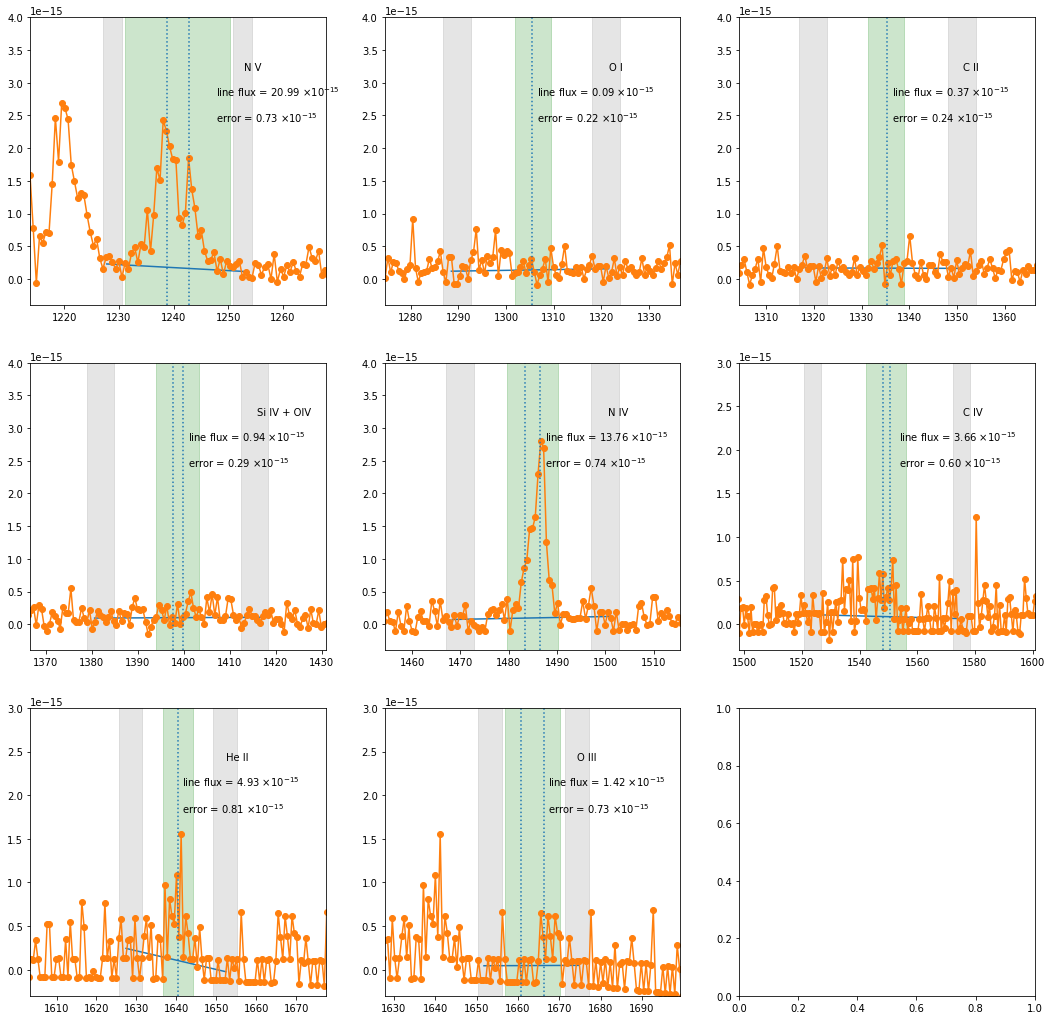

In [271]:
nrows = 3
ncols = 3
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (6*ncols, 6*nrows), sharey = False)

ebv = 0.047
a_v = 3.1*ebv

wav = spec[1].data['WAVELENGTH'][0]/(1+z)
flux = spec[1].data['FLUX'][0]
bound = 10
int_bound = 8
emflux, emerror = plot_region(axes[0,0], wav, flux, [1238.8, 1242.8], error = spec[1].data['ERROR'][0], 
                     linename = 'N V', bound = bound, int_bound = int_bound, xlim =15, ylim = 4e-15)
fuv_lineflux[ind]['NV1238'] = emflux
fuv_lineflux[ind]['d_NV1238'] = emerror
print(emflux)

wav = spec[1].data['WAVELENGTH'][0]/(1+z)
flux = spec[1].data['FLUX'][0]
bound = 16
int_bound = 4
emflux, emerror = plot_region(axes[0,1], wav, flux, [1305.53],  error = spec[1].data['ERROR'][0],
                     linename = 'O I', bound = bound, int_bound = int_bound, 
                     xlim =15, ylim = 4e-15,cont_bound = 5)
fuv_lineflux[ind]['OI1305'] = emflux
fuv_lineflux[ind]['d_OI1305'] = emerror
print(emflux)

wav = spec[1].data['WAVELENGTH'][0]/(1+z)
flux = spec[1].data['FLUX'][0]
bound = 16
int_bound = 4
emflux, emerror = plot_region(axes[0,2], wav, flux, [1335.31],  error = spec[1].data['ERROR'][0],
                     linename = 'C II', bound = bound, int_bound = int_bound, 
                     xlim =15, ylim = 4e-15,cont_bound = 5)
fuv_lineflux[ind]['CII1335'] = emflux
fuv_lineflux[ind]['d_CII1335'] = emerror
print(emflux)


wav = spec[1].data['WAVELENGTH'][0]/(1+z)
flux = spec[1].data['FLUX'][0]
bound = 16
int_bound = 4
emflux, emerror = plot_region(axes[1,0], wav, flux, [1397.6, 1399.8],  error = spec[1].data['ERROR'][0],
                     linename = 'Si IV + OIV', bound = bound, 
                     int_bound = int_bound,cont_bound = 5,xlim =15, ylim = 4e-15)
fuv_lineflux[ind]['SiIV1398'] = emflux
fuv_lineflux[ind]['d_SiIV1398'] = emerror
print(emflux)

bound = 14
int_bound = 4
emflux, emerror = plot_region(axes[1,1], wav, flux, [ 1483.3, 1486.5],  error = spec[1].data['ERROR'][0],
                     linename = 'N IV', bound = bound, int_bound = int_bound, 
                     xlim =15, ylim = 4e-15,cont_bound = 5)
fuv_lineflux[ind]['NIV1483'] = emflux
fuv_lineflux[ind]['d_NIV1483'] = emerror
print(emflux,emflux*4.8/2.72)

bound = 25
int_bound = 6
emflux, emerror = plot_region(axes[1,2], wav, flux, [1548.2, 1550.7],  error = spec[1].data['ERROR'][0],
                     linename = 'C IV', bound = bound, int_bound = int_bound, 
                     xlim =25, ylim = 3e-15,cont_bound = 5)
fuv_lineflux[ind]['CIV1548'] = emflux
fuv_lineflux[ind]['d_CIV1548'] = emerror
print(emflux,emflux*4.8/1.14)

bound = 12
int_bound = 4
emflux, emerror = plot_region(axes[2,0], wav, flux, [1640.4],  error = spec[1].data['ERROR'][0],
                     linename = 'He II', bound = bound, int_bound = int_bound, 
                     xlim =25, ylim = 3e-15,cont_bound = 5)
fuv_lineflux[ind]['HeII1640'] = emflux
fuv_lineflux[ind]['d_HeII1640'] = emerror
print(emflux,emflux*4.8/0.88)

bound = 8
int_bound = 4
emflux, emerror = plot_region(axes[2,1], wav, flux, [1660.8, 1666.2],  error = spec[1].data['ERROR'][0],
                     linename = 'O III', bound = bound, int_bound = int_bound, 
                     xlim =25, ylim = 3e-15,cont_bound = 5)
fuv_lineflux[ind]['OIII1660'] = emflux
fuv_lineflux[ind]['d_OIII1660'] = emerror
#print(emflux*4.8/0.88)

plt.savefig('./line_plots/2005ip_d3042FUV.png')

(1500.0, 3200.0)

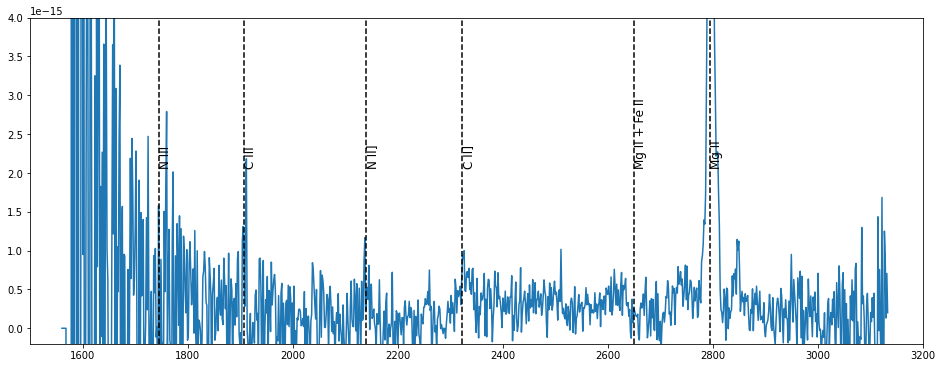

In [481]:
obj = '2005ip'                                                  
spec = fits.open('./reduced_spectra/2005ip/2005ip_d3042NUV_x1d.fits')
ebv = 0.047                                                       #update this!!!
                                                            #update this!!!

z = z_dict[obj]
nuv_lineflux[ind]['obj'] = obj
a_v = 3.1*ebv
ind = 0
nuv_lineflux[ind]['obj'] = '2005ip'
nuv_lineflux[ind]['phase'] = 3042

scale = 2
wav = spec[1].data['WAVELENGTH'][0]/(1+z)
flux = spec[1].data['FLUX'][0]*scale
error = spec[1].data['ERROR'][0]*scale

plt.figure(figsize=(16, 6))
plt.plot(wav, flux)
       
xcoords=[1746   ,1907   ,2139   ,2323   ,2650           , 2795  ]
#xcoords=np.asarray(xcoords)*1.e-4
names=['N III','C III','N II]','C II]','Mg II + Fe II','Mg II']

for i in range(len(xcoords)):
    if xcoords[i]<max(wav) and xcoords[i]>min(wav):
        plt.axvline(x=xcoords[i],ymax=1,color='black',linestyle='--')
        plt.text(xcoords[i],2.1e-15,names[i],rotation=90,fontsize=12)

plt.ylim(-2e-16, 4e-15)
plt.xlim(1500, 3200)

1.2545642895558528e-14 2.0006340830126558e-14
1.2427517672284974e-14 2.339297444194819e-14


obj,phase,NIII1746,d_NIII1746,CIII1907,d_CIII1907,NII2139,d_NII2139,CII2323,d_CII2323,MgIIFeII2650,d_MgIIFeII2650,MgII2795,d_MgII2795
str18,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2005ip,3042,1.2545642895558528e-14,2.7552149962369307e-15,1.2427517672284974e-14,1.1946474530305165e-15,6.9509261929001235e-15,5.514914104320039e-16,4.657668527068348e-15,4.3672371324791424e-16,-6.16068820571824e-16,2.7485614540044744e-16,1.3188504924376068e-13,1.2349156616872758e-15


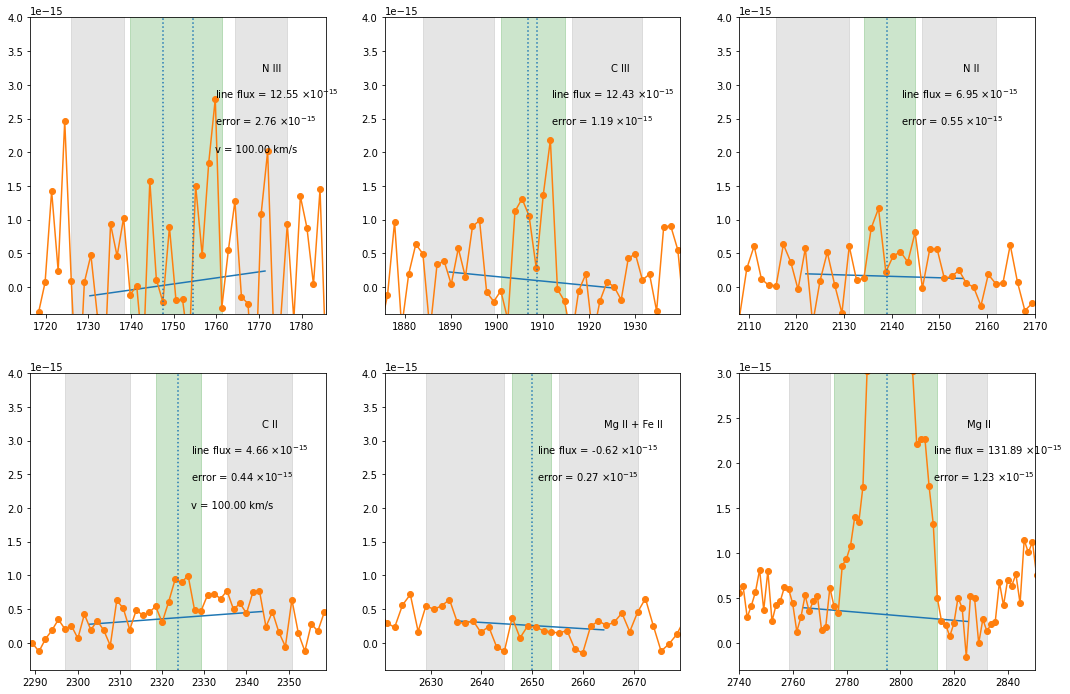

In [500]:
nrows = 2
ncols = 3
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (6*ncols, 6*nrows), sharey = False)
names=['N III','C III','N II]','C II]','Mg II + Fe II','Mg II']

#nuv_lineflux = at.Table([['SNnamewhateverlong'],[0],[0.],[0.],[0.],[0.],[0.],[0.],[0.],[0.],[0.],[0.],[0.],[0.]],
#                       names=('obj', 'phase', 'NIII1746', 'd_NIII1746', 'CIII1907', 'd_CIII1907', 
#                              'NII2139', 'd_NII2139', 'CII2323','d_CII2323','MgIIFeII2650','d_MgIIFeII2650',
#                             'MgII2795', 'd_MgII2795'))

cont_bound = 5

bound = 16
int_bound = 8
v_shift = 1e2
emflux, emerror = plot_region(axes[0,0], wav, flux, [1746.8, 1754], error = spec[1].data['ERROR'][0], 
                     linename = 'N III',cont_bound = 4, bound = bound, int_bound = int_bound, 
                              xlim =15, ylim = 4e-15, v_shift = v_shift)
nuv_lineflux[ind]['NIII1746'] = emflux
nuv_lineflux[ind]['d_NIII1746'] = emerror
print(emflux,emflux*4.8/3.01)


bound = 16
int_bound = 6
v_shift = 0
emflux, emerror = plot_region(axes[0,1], wav, flux, [1906.7, 1908.7],  error = spec[1].data['ERROR'][0],
                     linename = 'C III', bound = bound, int_bound = int_bound, cont_bound = cont_bound,
                     xlim =15, ylim = 4e-15, v_shift = v_shift)
nuv_lineflux[ind]['CIII1907'] = emflux
nuv_lineflux[ind]['d_CIII1907'] = emerror
print(emflux,emflux*4.8/2.55)


bound = 16
int_bound = 6
v_shift = 0
emflux, emerror = plot_region(axes[0,2], wav, flux, [2139],  error = spec[1].data['ERROR'][0],
                     linename = 'N II', bound = bound, int_bound = int_bound, 
                     xlim =15, ylim = 4e-15,cont_bound = cont_bound, v_shift = v_shift)
nuv_lineflux[ind]['NII2139'] = emflux
nuv_lineflux[ind]['d_NII2139'] = emerror



bound = 20
int_bound = 6
v_shift = 1e2
emflux, emerror = plot_region(axes[1,0], wav, flux, [2323],  error = spec[1].data['ERROR'][0],
                     linename = 'C II', bound = bound, v_shift = v_shift, 
                     int_bound = int_bound,cont_bound = cont_bound,xlim =15, ylim = 4e-15)
nuv_lineflux[ind]['CII2323'] = emflux
nuv_lineflux[ind]['d_CII2323'] = emerror

bound = 14
int_bound = 4
v_shift = 0
emflux, emerror = plot_region(axes[1,1], wav, flux, [2650],  error = spec[1].data['ERROR'][0],
                     linename = 'Mg II + Fe II ', bound = bound, int_bound = int_bound, 
                     xlim =15, ylim = 4e-15,cont_bound = cont_bound, v_shift = v_shift)
nuv_lineflux[ind]['MgIIFeII2650'] = emflux
nuv_lineflux[ind]['d_MgIIFeII2650'] = emerror

bound = 30
int_bound = 20
v_shift = 0
emflux, emerror = plot_region(axes[1,2], wav, flux, [2795],  error = spec[1].data['ERROR'][0],
                     linename = 'Mg II', bound = bound, int_bound = int_bound, 
                     xlim =25, ylim = 3e-15,cont_bound = cont_bound, v_shift = v_shift)
nuv_lineflux[ind]['MgII2795'] = emflux
nuv_lineflux[ind]['d_MgII2795'] = emerror

plt.savefig('./line_plots/2005ip_d3042NUV.png')
nuv_lineflux

# cell for calculating normalization factor from NUV to FUV

In [764]:
def calc_normalization(fuvspec, nuvspec, fuv_cut_edge = 40, nuv_cut_edge =40):
    fuv = fits.open(fuvspec)
    nuv = fits.open(nuvspec)
    fuv_ind = fuv[1].data['WAVELENGTH'][0]>nuv[1].data['WAVELENGTH'][0][nuv_cut_edge]
    nuv_ind = nuv[1].data['WAVELENGTH'][0]<fuv[1].data['WAVELENGTH'][0][-fuv_cut_edge]
    scale = (453*4+634*8)/634/((675*4+699*4)/675)#np.average(fuv[1].data['FLUX'][0][fuv_ind][:-fuv_cut_edge])/np.average(nuv[1].data['FLUX'][0][nuv_ind][nuv_cut_edge:])
    print(np.average(fuv[1].data['FLUX'][0][fuv_ind][:-fuv_cut_edge]),np.average(nuv[1].data['FLUX'][0][nuv_ind][nuv_cut_edge:]))
    plt.plot(fuv[1].data['WAVELENGTH'][0][:-fuv_cut_edge], fuv[1].data['FLUX'][0][:-fuv_cut_edge],
              alpha = 0.6)
    plt.plot(nuv[1].data['WAVELENGTH'][0][nuv_cut_edge:], nuv[1].data['FLUX'][0][nuv_cut_edge:]*scale,
              alpha = 0.6)
    print(len(fuv[1].data['FLUX'][0]))
    plt.axhline(np.median(fuv[1].data['WAVELENGTH'][0][fuv_ind][:-fuv_cut_edge]), linestyle = ':')
    plt.xlim(nuv[1].data['WAVELENGTH'][0][nuv_cut_edge]-100, fuv[1].data['WAVELENGTH'][0][-fuv_cut_edge]+100)
    return scale

-1.5331124e-16 4.0696942e-16
1024
1.7753416508303725


(1100.0, 3300.0)

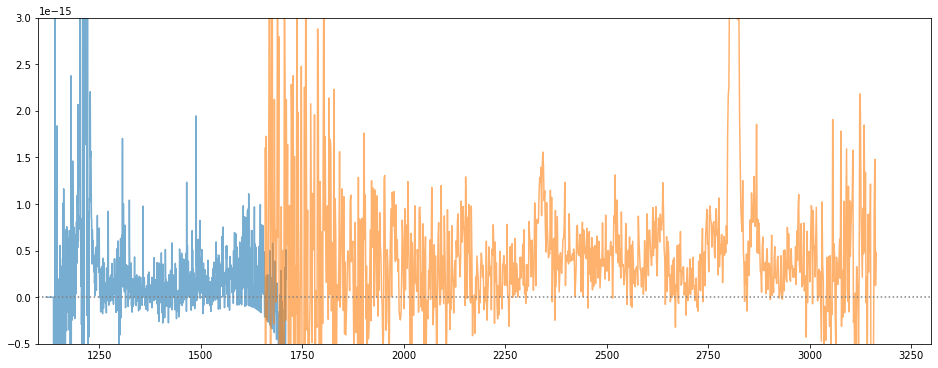

In [784]:
plt.figure(figsize=(16, 6))
scale = calc_normalization('./reduced_spectra/2005ip/2005ip_d4337FUV_x1d.fits',
                  './reduced_spectra/2005ip/2005ip_d4337NUV_x1d.fits',
                  fuv_cut_edge =10, nuv_cut_edge =50)
#FUV (453*4+634*8)/634
#NUV (675*4+699*4)/675
print(scale)
plt.axhline(0, color = 'grey', linestyle = ':')
plt.ylim(-5e-16, 3e-15)
plt.xlim(1100, 3300)

# workground

In [785]:
nuv_lineflux.add_row(init_row)
ascii.write(nuv_lineflux, 'nuv_lineflux.dat', overwrite=True)  
nuv_lineflux

obj,phase,NIII1746,d_NIII1746,CIII1907,d_CIII1907,NII2139,d_NII2139,CII2323,d_CII2323,MgIIFeII2650,d_MgIIFeII2650,MgII2795,d_MgII2795
str18,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2005ip,3042,1.2545642895558528e-14,2.7552149962369307e-15,1.2427517672284974e-14,1.1946474530305165e-15,6.9509261929001235e-15,5.514914104320039e-16,4.657668527068348e-15,4.3672371324791424e-16,-6.16068820571824e-16,2.7485614540044744e-16,1.3188504924376068e-13,1.2349156616872758e-15
2021csp,7,-1.623843674843143e-15,4.576225153754114e-16,2.337914393657833e-15,1.8435232598520577e-16,1.2779681573696947e-16,1.1828109859417275e-16,-1.4422116656146452e-15,1.1224027378850078e-16,-3.82360901642134e-17,9.934855696501269e-17,7.377178029150523e-16,3.798152269758618e-16
2021csp,11,4.0551804424706825e-17,4.522640638286372e-16,-7.306499600411949e-17,1.576457871404716e-16,-2.0260937532317456e-16,1.3008810595957754e-16,3.543209117639262e-16,1.236460956823161e-16,3.6535047145181633e-16,1.1546584799324885e-16,-1.2765653976027276e-15,2.4785264995473954e-16
2015G,12,4.8173607498191794e-14,1.890588912285918e-15,-9.747777447721728e-15,5.881532771531051e-16,-1.5649787860103008e-14,3.597985494167334e-16,-1.4713334888882417e-15,2.67169422846726e-16,-1.1939470834954957e-15,1.6891106233198574e-16,3.335515531194934e-14,5.290136398924715e-16
2020nxt,18,5.193964717435496e-15,7.363504539262741e-16,1.8647210241821974e-14,6.535637499874699e-16,-1.22214021128063e-15,2.179699649672091e-16,6.7820648538594266e-15,2.9636875383421973e-16,4.982838350847821e-16,1.7538977126129996e-16,2.805664950974009e-14,7.836548824390218e-16
2020nxt,27,8.649275141767512e-15,1.2592202941093746e-15,9.981572270122786e-15,8.995231655420144e-16,1.8529820032979103e-15,3.0970585497760277e-16,5.04963783955553e-15,3.655618583403609e-16,-3.859682768591144e-16,1.8714351782989715e-16,3.784152437184328e-14,9.242822517182602e-16
2010jl,23,4.822974418315502e-13,2.6727218930923094e-14,2.3249629522698955e-13,1.3931272832327905e-14,1.56430479561968e-13,3.5434397056893022e-15,8.760284674790205e-14,2.3738763575317017e-15,8.926272557875981e-15,1.6984737383117604e-15,4.789130380455444e-13,4.113967199397921e-15
2010jl,34,5.272587306106388e-13,2.8247005131343333e-14,2.470459151930761e-13,1.326889994357914e-14,1.742357926553672e-13,3.3233839345211493e-15,8.664085779150629e-14,2.1977353291593407e-15,1.2607317122895657e-14,1.733286337701367e-15,5.668319978150969e-13,4.1134155791138864e-15
2010jl,95,6.014444406554205e-13,5.2912834005879266e-14,2.7540205895167613e-13,1.4213373704616886e-14,2.2171920437378177e-13,3.787381577720997e-15,1.2096241052462136e-13,2.451014535815672e-15,1.3615991780557495e-14,1.8670931726966302e-15,1.6291012231836403e-12,5.456880899422966e-15


In [787]:
nuv_lineflux[16]

obj,phase,NIII1746,d_NIII1746,CIII1907,d_CIII1907,NII2139,d_NII2139,CII2323,d_CII2323,MgIIFeII2650,d_MgIIFeII2650,MgII2795,d_MgII2795
str18,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2020aekp,250,-8.537746556290602e-17,4.934212537833739e-16,2.009688328031297e-15,3.0755657892275407e-16,7.287582222685809e-16,1.8108947259546506e-16,7.312187570292407e-16,1.452769893706434e-16,-4.722939830535952e-17,9.654410882549725e-17,5.6538335051396465e-15,4.959329331235367e-16


In [574]:
scale = 1.

In [781]:
from __future__ import print_function
from astropy.coordinates import SkyCoord
from dustmaps.sfd import SFDQuery

coords = SkyCoord('09h32m06.4s', '8d26m44.4s', frame='icrs')
sfd = SFDQuery()
ebv = sfd(coords)
print('E(B-V) = {:.3f} mag'.format(ebv))


E(B-V) = 0.047 mag


(1500.0, 3200.0)

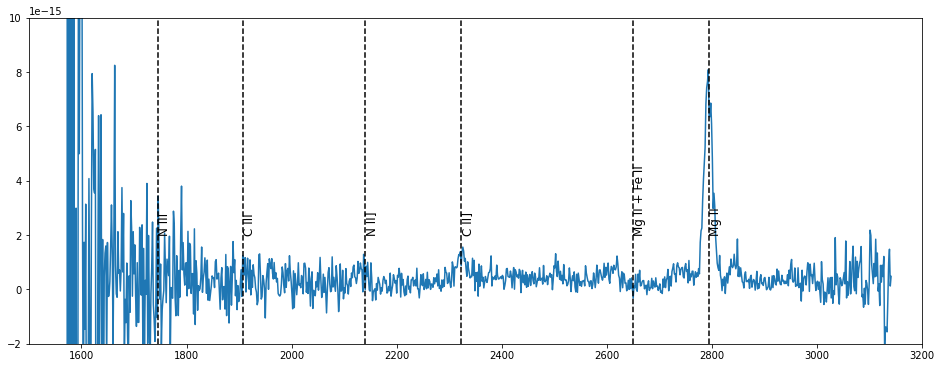

In [788]:
# for object dont need binning
obj = '2005ip'                                                  
spec = fits.open('./reduced_spectra/2005ip/2005ip_d4337NUV_x1d.fits')
ebv = 0.047                                                      #update this!!!
ind = 17                                                          #update this!!!
nuv_lineflux[ind]['phase'] = 4337                                    #update this!!!

#2021csp ebv=0.03

z = z_dict[obj]
nuv_lineflux[ind]['obj'] = obj
a_v = 3.1*ebv

wav = spec[1].data['WAVELENGTH'][0]/(1+z)
flux = spec[1].data['FLUX'][0]*scale                        
error = spec[1].data['ERROR'][0]*scale  

plt.figure(figsize=(16, 6))
plt.plot(wav, flux)

xcoords=[1746   ,1907   ,2139   ,2323   ,2650           , 2795  ]
#xcoords=np.asarray(xcoords)*1.e-4
names=['N III','C III','N II]','C II]','Mg II + Fe II','Mg II']

for i in range(len(xcoords)):
    if xcoords[i]<max(wav) and xcoords[i]>min(wav):
        plt.axvline(x=xcoords[i],ymax=1,color='black',linestyle='--')
        plt.text(xcoords[i],2.1e-15,names[i],rotation=90,fontsize=12)

plt.ylim(-2e-15, 1e-14)
plt.xlim(1500, 3200)

In [678]:
ind1 = (wav>1720)&(wav<1760)
flux[79] = (flux[78]+flux[80])/2

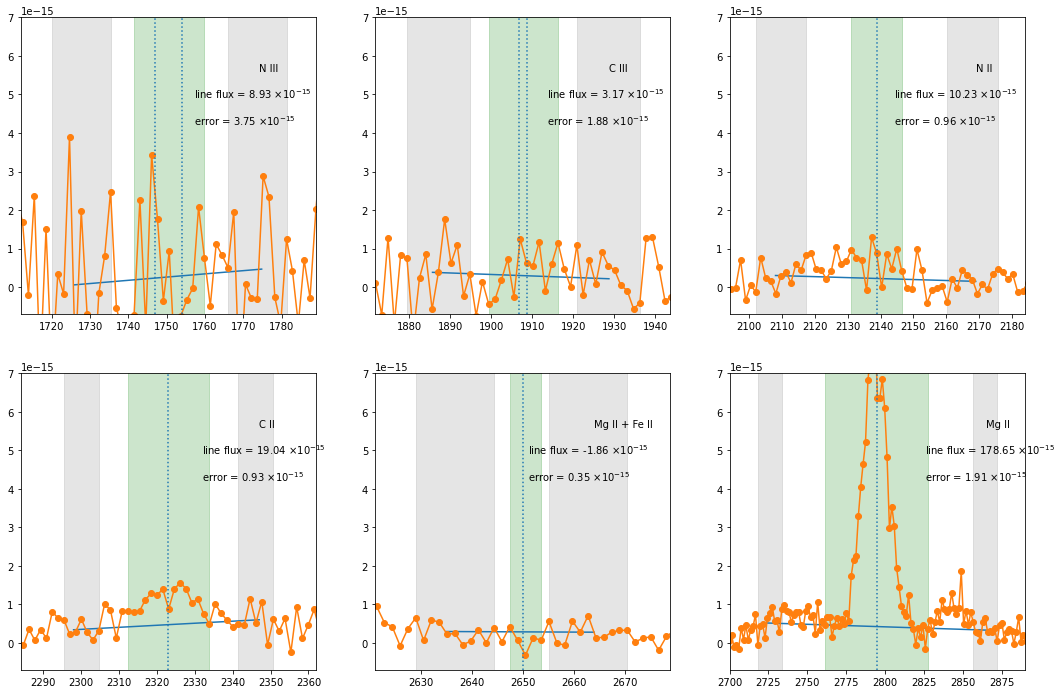

In [794]:
nrows = 2
ncols = 3
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (6*ncols, 6*nrows), sharey = False)
#names=['N III','C III','N II]','C II]','Mg II + Fe II','Mg II']

#nuv_lineflux = at.Table([['SNnamewhateverlong'],[0],[0.],[0.],[0.],[0.],[0.],[0.],[0.],[0.],[0.],[0.],[0.],[0.]],
#                       names=('obj', 'phase', 'NIII1746', 'd_NIII1746', 'CIII1907', 'd_CIII1907', 
#                              'NII2139', 'd_NII2139', 'CII2323','d_CII2323','MgIIFeII2650','d_MgIIFeII2650',
#                             'MgII2795', 'd_MgII2795'))

cont_bound = 5
ylim = 7e-15
bound = 20
int_bound = 6
v_shift = 0
emflux, emerror = plot_region(axes[0,0], wav, flux, [1746.8, 1754], error = spec[1].data['ERROR'][0], 
                     linename = 'N III',cont_bound = cont_bound, bound = bound, int_bound = int_bound, 
                              xlim =15, ylim = ylim, v_shift = v_shift)
nuv_lineflux[ind]['NIII1746'] = emflux
nuv_lineflux[ind]['d_NIII1746'] = emerror


bound = 20
int_bound = 8
v_shift = 0
emflux, emerror = plot_region(axes[0,1], wav, flux, [1906.7, 1908.7],  error = spec[1].data['ERROR'][0],
                     linename = 'C III', bound = bound, int_bound = int_bound, cont_bound = cont_bound,
                     xlim =15, ylim = ylim, v_shift = v_shift)
nuv_lineflux[ind]['CIII1907'] = emflux
nuv_lineflux[ind]['d_CIII1907'] = emerror

bound = 30
int_bound = 8
v_shift = 0
emflux, emerror = plot_region(axes[0,2], wav, flux, [2139],  error = spec[1].data['ERROR'][0],
                     linename = 'N II', bound = bound, int_bound = int_bound, 
                     xlim =15, ylim = ylim,cont_bound = cont_bound, v_shift = v_shift)
nuv_lineflux[ind]['NII2139'] = emflux
nuv_lineflux[ind]['d_NII2139'] = emerror



bound = 24
int_bound = 12
v_shift = 0
emflux, emerror = plot_region(axes[1,0], wav, flux, [2323],  error = spec[1].data['ERROR'][0],
                     linename = 'C II', bound = bound, v_shift = v_shift, 
                     int_bound = int_bound,cont_bound = 3,xlim =15, ylim = ylim)
nuv_lineflux[ind]['CII2323'] = emflux
nuv_lineflux[ind]['d_CII2323'] = emerror

bound = 14
int_bound = 4
v_shift = 0
emflux, emerror = plot_region(axes[1,1], wav, flux, [2650],  error = spec[1].data['ERROR'][0],
                     linename = 'Mg II + Fe II ', bound = bound, int_bound = int_bound, 
                     xlim =15, ylim = ylim,cont_bound = cont_bound, v_shift = v_shift)
nuv_lineflux[ind]['MgIIFeII2650'] = emflux
nuv_lineflux[ind]['d_MgIIFeII2650'] = emerror

bound = 70
int_bound = 34
v_shift = 0
emflux, emerror = plot_region(axes[1,2], wav, flux, [2795],  error = spec[1].data['ERROR'][0],
                     linename = 'Mg II', bound = bound, int_bound = int_bound, 
                     xlim =25, ylim = ylim,cont_bound = cont_bound, v_shift = v_shift)
nuv_lineflux[ind]['MgII2795'] = emflux
nuv_lineflux[ind]['d_MgII2795'] = emerror

#nuv_lineflux

In [645]:
527.26/13.5/566.83*25.6

1.7639171977227477

In [777]:
fig.savefig('./line_plots/2020aekp_d250NUV.png')


# notes:
### 2020nxt:
both NUV: double peak and an absorption at Mg II 
### 2021csp
day 8: likely p cygni profile for N V, C II, Si IV, C IV, need to fit seperately...
        OI hard to find continuum...
FUV and NUV: taken in STIS and COS and seems hard to renormalize
### 2010jl
day 23: very similar velocity
day 34: a peak at blue side near C III (noise? Si III?)
need a profile fitting to get rid of MW MG II lines.... It's overall underestimated in our fitting.
day 95: C III line is significantly weaker than that in paper...
         or maybe N III is too strong?
day 554: C II profile seems complicated, line blending?
day 1226: use average to renormalize the flux. Normalize by exposure time/no of exposures doesn't look good
          featureless
day 1616: skipped remornalize FUV/NUV
### 1998S
day 71: blueward of C III line, likely a strong Fe II line
        also some Mg II absoption from host maybe

# workground for FUV

In [372]:
#fuv_lineflux.remove_row(10)
ascii.write(fuv_lineflux, 'fuv_lineflux.dat', overwrite=True)  


(1100.0, 1700.0)

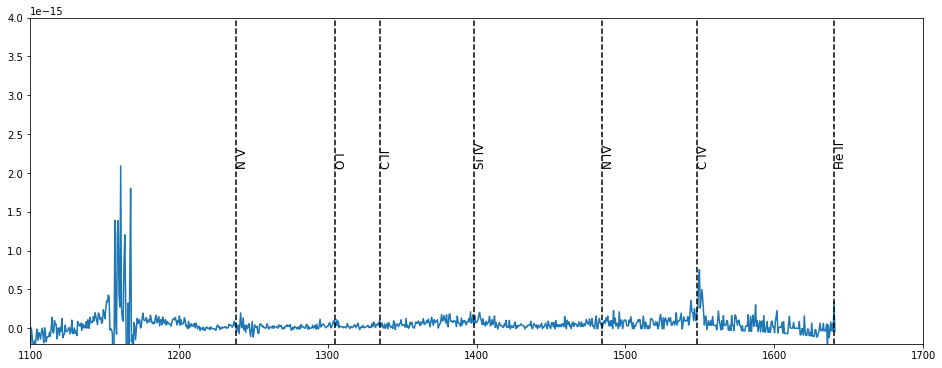

In [363]:
# for object dont need binning
obj = '2020aekp'                                                  
spec = fits.open('./reduced_spectra/2020aekp/2020aekp_d250FUV_x1d.fits')
ebv = 0.03                                                       #update this!!!
ind = 9                                                            #update this!!!
fuv_lineflux[ind]['phase'] = 250                                    #update this!!!

z = z_dict[obj]
fuv_lineflux[ind]['obj'] = obj
a_v = 3.1*ebv

wav = spec[1].data['WAVELENGTH'][0]/(1+z)
flux = spec[1].data['FLUX'][0]
error = spec[1].data['ERROR'][0]

plt.figure(figsize=(16, 6))
plt.plot(wav, flux)

xcoords=[1238, 1305, 1335, 1398,1484  ,1548  ,1640  ,1660]
#xcoords=np.asarray(xcoords)*1.e-4
names=['N V', 'O I', 'C II', 'Si IV','N IV','C IV','He II','O III']
       
for i in range(len(xcoords)):
    if xcoords[i]<max(wav) and xcoords[i]>min(wav):
        plt.axvline(x=xcoords[i],ymax=1,color='black',linestyle='--')
        plt.text(xcoords[i],2.1e-15,names[i],rotation=90,fontsize=12)

plt.ylim(-2e-16, 4e-15)
plt.xlim(1100, 1700)

(1000.0, 2000.0)

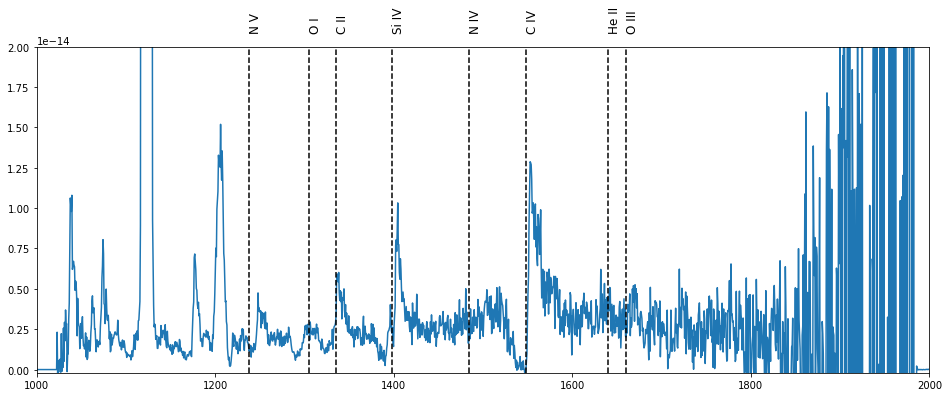

In [304]:
#spectra need binning
obj = '2021csp'                                          #update this!!!
spec = fits.open('./reduced_spectra/2021csp/2021csp_d8FUV.fits')#update this!!!
z = z_dict[obj]
ebv = 0.028                                             #update this!!!
a_v = 3.1*ebv
ind = 2                                                  #update this!!!
fuv_lineflux[ind]['obj'] = obj
fuv_lineflux[ind]['phase'] = 8                               #update this!!!

wav = spec[1].data['WAVELENGTH'][0]/(1+z)
flux = spec[1].data['FLUX'][0]
error = spec[1].data['ERROR'][0]

plt.figure(figsize=(16, 6))
bin_size=8
f_bin = np.zeros(int(len(wav)/bin_size))
wav_bin = np.zeros(int(len(wav)/bin_size))
err_bin = np.zeros(int(len(wav)/bin_size))

for i in range(int(len(wav)/bin_size)):
    wav_bin[i] = np.average(wav[i*bin_size:i*bin_size+bin_size])
    f_bin[i] = np.sum(flux[i*bin_size:i*bin_size+bin_size])
    err_bin[i] = np.sqrt(np.average(error[i*bin_size:i*bin_size+bin_size]**2))

plt.plot(wav_bin, f_bin)

xcoords=[1238, 1305, 1335, 1398,1484  ,1548  ,1640  ,1660]
#xcoords=np.asarray(xcoords)*1.e-4
names=['N V', 'O I', 'C II', 'Si IV','N IV','C IV','He II','O III']
       
for i in range(len(xcoords)):
    if xcoords[i]<max(wav) and xcoords[i]>min(wav):
        plt.axvline(x=xcoords[i],ymax=1,color='black',linestyle='--')
        plt.text(xcoords[i],2.1e-14,names[i],rotation=90,fontsize=12)

plt.ylim(-2e-16, 2e-14)
plt.xlim(1000, 2000)

In [250]:
len(wav_bin)

2048

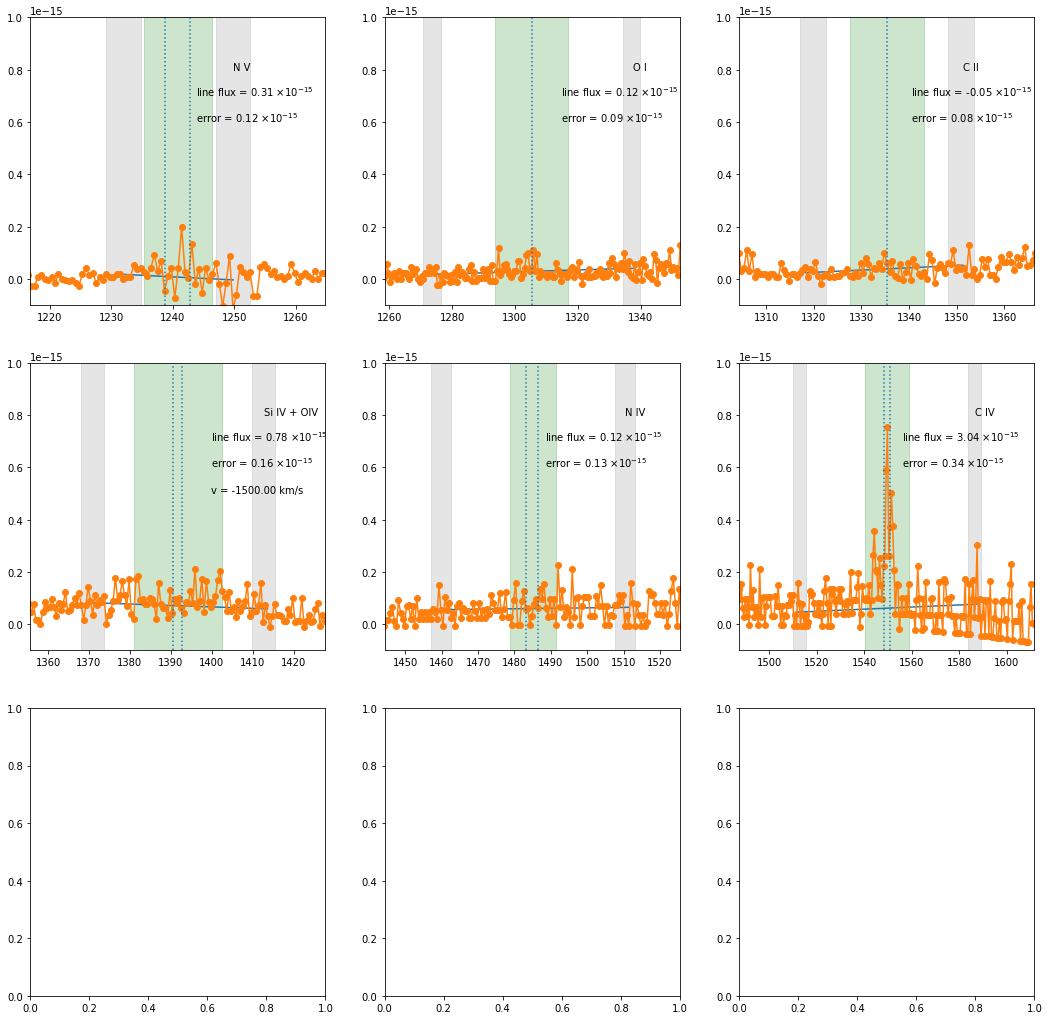

In [364]:
nrows = 3
ncols = 3
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (6*ncols, 6*nrows), sharey = False)



wav = spec[1].data['WAVELENGTH'][0]/(1+z)#wav_bin#
flux = spec[1].data['FLUX'][0]#f_bin#
error = spec[1].data['ERROR'][0]#err_bin#
cont_bound = 5#40

bound = 7
int_bound = 4
v_shift = 0
ylim = 1e-15
emflux, emerror = plot_region(axes[0,0], wav, flux, [1238.8, 1242.8], error = error, 
                     linename = 'N V', bound = bound, int_bound = int_bound, v_shift = v_shift, 
                              xlim =15, ylim = ylim, cont_bound = cont_bound)
fuv_lineflux[ind]['NV1238'] = emflux
fuv_lineflux[ind]['d_NV1238'] = emerror

#cont_bound = 8
bound = 32
int_bound = 12
v_shift = 0
emflux, emerror = plot_region(axes[0,1], wav, flux, [1305.53],  error = error,
                     linename = 'O I', bound = bound, int_bound = int_bound, v_shift = v_shift, 
                     xlim =15, ylim = ylim,cont_bound = cont_bound)
fuv_lineflux[ind]['OI1305'] = emflux
fuv_lineflux[ind]['d_OI1305'] = emerror

bound = 16
int_bound = 8
v_shift = 0
emflux, emerror = plot_region(axes[0,2], wav, flux, [1335.31],  error = error,
                     linename = 'C II', bound = bound, int_bound = int_bound, v_shift = v_shift, 
                     xlim =15, ylim = ylim,cont_bound = cont_bound)
fuv_lineflux[ind]['CII1335'] = emflux
fuv_lineflux[ind]['d_CII1335'] = emerror


bound = 20
int_bound = 10
v_shift = -1.5e3
emflux, emerror = plot_region(axes[1,0], wav, flux, [1397.6, 1399.8],  error = error,
                     linename = 'Si IV + OIV', bound = bound, v_shift = v_shift, 
                     int_bound = int_bound,cont_bound = cont_bound,xlim =15, ylim = ylim)
fuv_lineflux[ind]['SiIV1398'] = emflux
fuv_lineflux[ind]['d_SiIV1398'] = emerror

bound = 24
int_bound = 5
v_shift = 0
emflux, emerror = plot_region(axes[1,1], wav, flux, [ 1483.3, 1486.5],  error = error,
                     linename = 'N IV', bound = bound, int_bound = int_bound, v_shift = v_shift, 
                     xlim =15, ylim = ylim,cont_bound = cont_bound)
fuv_lineflux[ind]['NIV1483'] = emflux
fuv_lineflux[ind]['d_NIV1483'] = emerror

bound = 36
int_bound = 8
v_shift = 0.
emflux, emerror = plot_region(axes[1,2], wav, flux, [1548.2, 1550.7],  error = error,
                     linename = 'C IV', bound = bound, int_bound = int_bound, v_shift = v_shift, 
                     xlim =25, ylim = ylim,cont_bound = cont_bound)
fuv_lineflux[ind]['CIV1548'] = emflux
fuv_lineflux[ind]['d_CIV1548'] = emerror

bound = 24
int_bound = 6
v_shift = 0
emflux, emerror = plot_region(axes[2,0], wav, flux, [1640.4],  error = error,
                     linename = 'He II', bound = bound, int_bound = int_bound, v_shift = v_shift, 
                     xlim =25, ylim = ylim,cont_bound = cont_bound)
fuv_lineflux[ind]['HeII1640'] = emflux
fuv_lineflux[ind]['d_HeII1640'] = emerror

bound = 16
int_bound = 6
v_shift = 0
emflux, emerror = plot_region(axes[2,1], wav, flux, [1660.8, 1666.2],  error = error,
                     linename = 'O III', bound = bound, int_bound = int_bound, v_shift = v_shift, 
                     xlim =25, ylim = ylim,cont_bound = cont_bound)
fuv_lineflux[ind]['OIII1660'] = emflux
fuv_lineflux[ind]['d_OIII1660'] = emerror
#print(emflux*4.8/0.88)


In [365]:
fig.savefig('./line_plots/2020aekp_d250FUV.png')

# notes:
### 2005ip:
4337 spectrum: two line component on both sides of O I 1305 line, hard to tell which ones 
### 2021csp
day 8: likely p cygni profile for N V, C II, Si IV, C IV, need to fit seperately...
        OI hard to find continuum...
FUV and NUV: taken in STIS and COS and seems hard to renormalize
### 2020nxt
day 18: doublet near C IV, not sure what that is
       O III close to the edge and not an effective measurement
### 1998S
day 71: clear Si IV + O IV doublets. further line diagonise?
        O I  very broad blue line, can be explained by a blue shift of ~4500 km/s, but could that be real?
d 234 : Si IV + O IV disappear
        O I still high velocity. Maybe another line?
d 482
### 2020aekp
d203: basically only detect C IV 
      Si IV + O IV a small component at -1500km/s?
d250 similar as above

## 2021csp

(948.9300281581945, 2158.4418827675104)

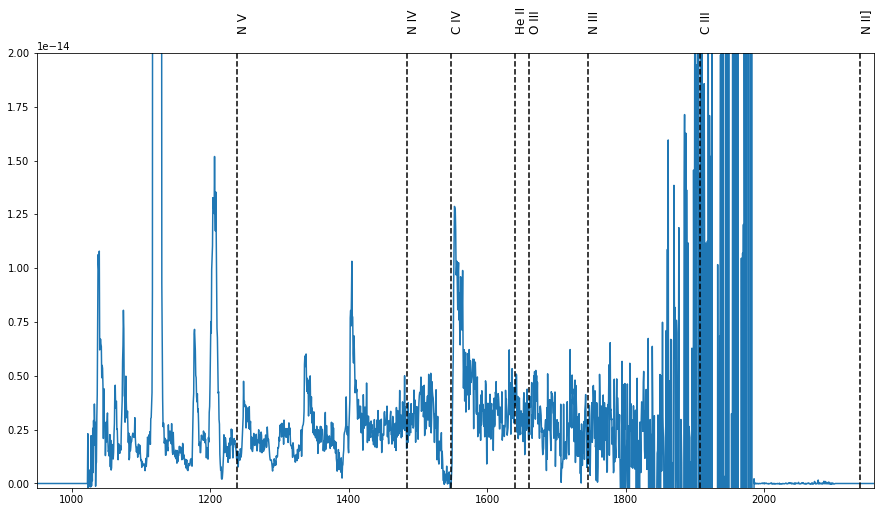

In [134]:
spec = fits.open('./reduced_spectra/2021csp/2021csp_d8FUV.fits')
z = z_dict['2021csp']
ebv = 0.028
a_v = 3.1*ebv

wav = spec[1].data['WAVELENGTH'][0]/(1+z)
flux = spec[1].data['FLUX'][0]

plt.figure(figsize=(15, 8))
bin_size=8
f_bin = np.zeros(int(len(wav)/bin_size))
wav_bin = np.zeros(int(len(wav)/bin_size))
for i in range(int(len(wav)/bin_size)):
    wav_bin[i] = np.average(wav[i*bin_size:i*bin_size+bin_size])
    f_bin[i] = np.sum(flux[i*bin_size:i*bin_size+bin_size])

plt.plot(wav_bin, f_bin)

xcoords=[1238,1484  ,1548  ,1640  ,1660    ,1746   ,1907   ,2139   ,2323   ,2650           , 2795  ]
#xcoords=np.asarray(xcoords)*1.e-4
names=['N V' ,'N IV','C IV','He II','O III','N III','C III','N II]','C II]','Mg II + Fe II','Mg II']
       
for i in range(len(xcoords)):
    if xcoords[i]<max(wav) and xcoords[i]>min(wav):
        plt.axvline(x=xcoords[i],ymax=1,color='black',linestyle='--')
        plt.text(xcoords[i],2.1e-14,names[i],rotation=90,fontsize=12)

plt.ylim(-2e-16, 2e-14)
plt.xlim(min(wav), max(wav))

-3.832071157065507e-15
7.041078632772391e-16 1.2425432881363042e-15
2.109168441992274e-15 8.880709229441154e-15
6.930134354294966e-16 3.78007328416089e-15


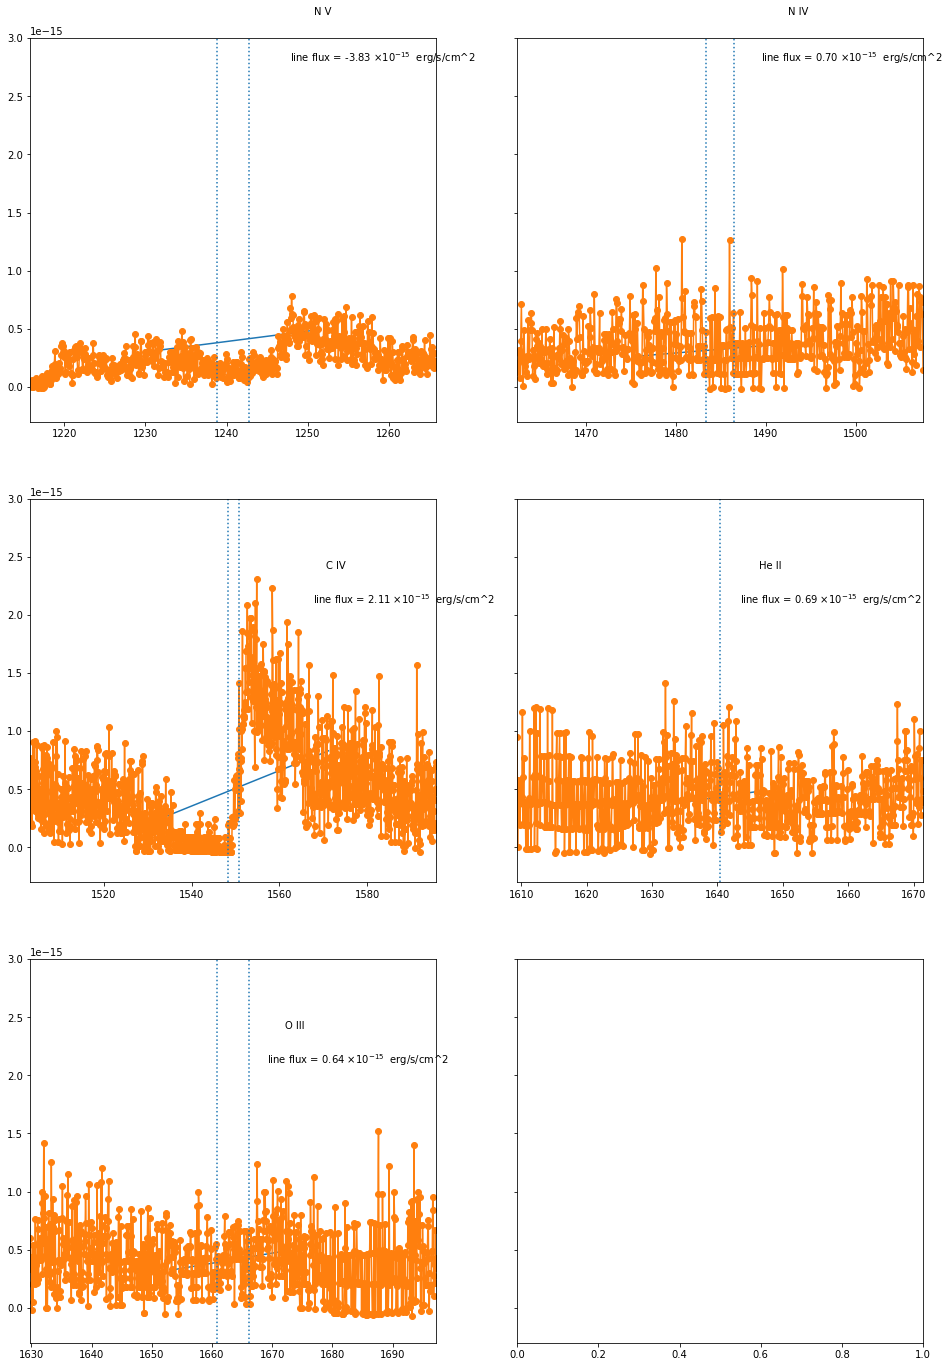

In [124]:
nrows = 3
ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (8*ncols, 8*nrows), sharey = True)

bound = 8
emflux = plot_region(axes[0,0], wav, flux, [1238.8, 1242.8], linename = 'N V', bound = bound, 
                     xlim =15, ylim = 4e-15)
print(emflux)

bound = 6
emflux = plot_region(axes[0,1], wav, flux, [ 1483.3, 1486.5], linename = 'N IV', bound = bound, 
                     xlim =15, ylim = 4e-15)
print(emflux,emflux*4.8/2.72)

bound = 20
emflux = plot_region(axes[1,0], wav, flux, [1548.2, 1550.7], linename = 'C IV', bound = bound, 
                     xlim =25, ylim = 3e-15)
print(emflux,emflux*4.8/1.14)

bound = 6
emflux = plot_region(axes[1,1], wav, flux, [1640.4], linename = 'He II', bound = bound, 
                     xlim =25, ylim = 3e-15)
print(emflux,emflux*4.8/0.88)

bound = 6
emflux = plot_region(axes[2,0], wav, flux, [1660.8, 1666.2], linename = 'O III', bound = bound, 
                     xlim =25, ylim = 3e-15)
#print(emflux*4.8/0.88)

(1451.862866956976, 2914.3984075592534)

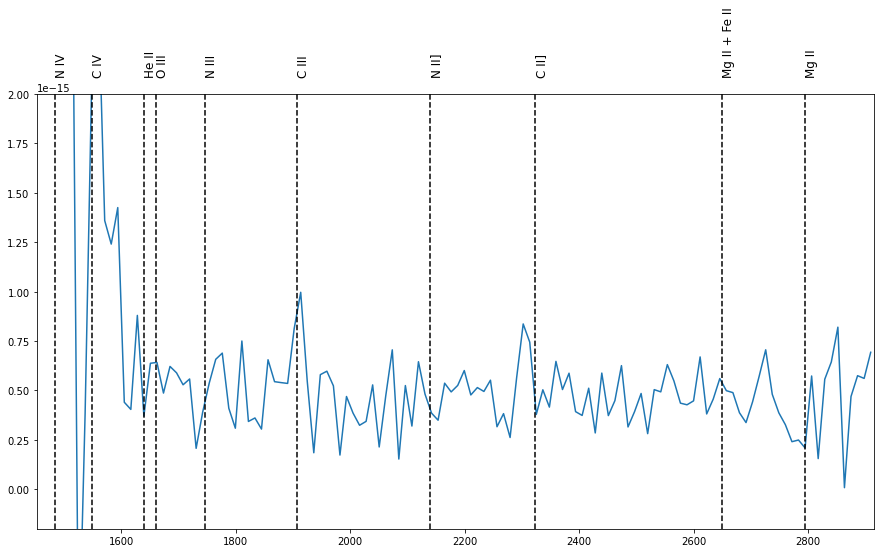

In [139]:
spec = fits.open('./reduced_spectra/2021csp/2021csp_d7NUV_x1d.fits')
z = z_dict['2021csp']
ebv = 0.028
a_v = 3.1*ebv

wav = spec[1].data['WAVELENGTH'][0]/(1+z)
flux = spec[1].data['FLUX'][0]

plt.figure(figsize=(15, 8))
if len(wav)>1024:
    bin_size=8
    f_bin = np.zeros(int(len(wav)/bin_size))
    wav_bin = np.zeros(int(len(wav)/bin_size))
    for i in range(int(len(wav)/bin_size)):
        wav_bin[i] = np.average(wav[i*bin_size:i*bin_size+bin_size])
        f_bin[i] = np.sum(flux[i*bin_size:i*bin_size+bin_size])

plt.plot(wav_bin, f_bin)

xcoords=[1238,1484  ,1548  ,1640  ,1660    ,1746   ,1907   ,2139   ,2323   ,2650           , 2795  ]
#xcoords=np.asarray(xcoords)*1.e-4
names=['N V' ,'N IV','C IV','He II','O III','N III','C III','N II]','C II]','Mg II + Fe II','Mg II']
       
for i in range(len(xcoords)):
    if xcoords[i]<max(wav) and xcoords[i]>min(wav):
        plt.axvline(x=xcoords[i],ymax=1,color='black',linestyle='--')
        plt.text(xcoords[i],2.1e-15,names[i],rotation=90,fontsize=12)

plt.ylim(-2e-16, 2e-15)
plt.xlim(min(wav), max(wav))

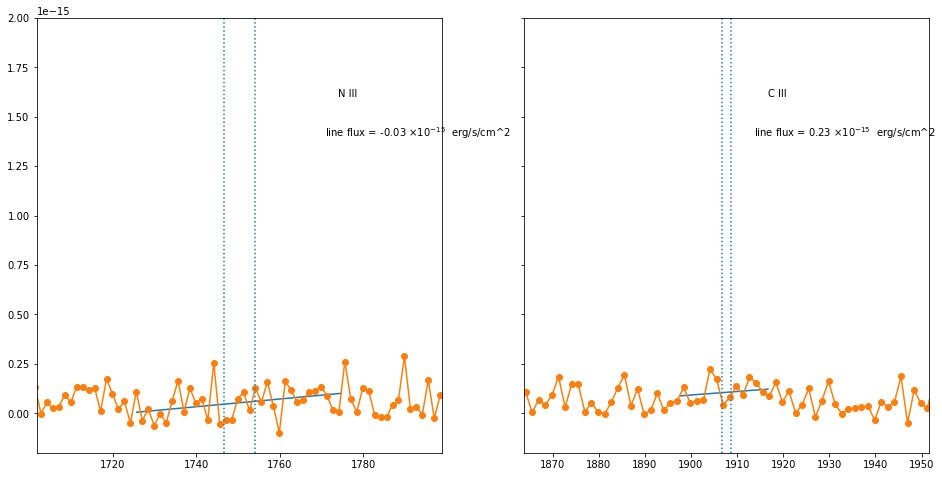

In [140]:
nrows = 1
ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (8*ncols, 8*nrows), sharey = True)

bound = 20
emflux = plot_region(axes[0], wav, flux, [ 1746.8,1754.0], linename = 'N III', bound = bound, 
                     xlim =25, ylim = 2e-15)

bound = 8
emflux = plot_region(axes[1], wav, flux, [ 1906.7, 1908.7], linename = 'C III', bound = bound, 
                     xlim =35, ylim = 2e-15)

(948.9253154739968, 2158.4311547543293)

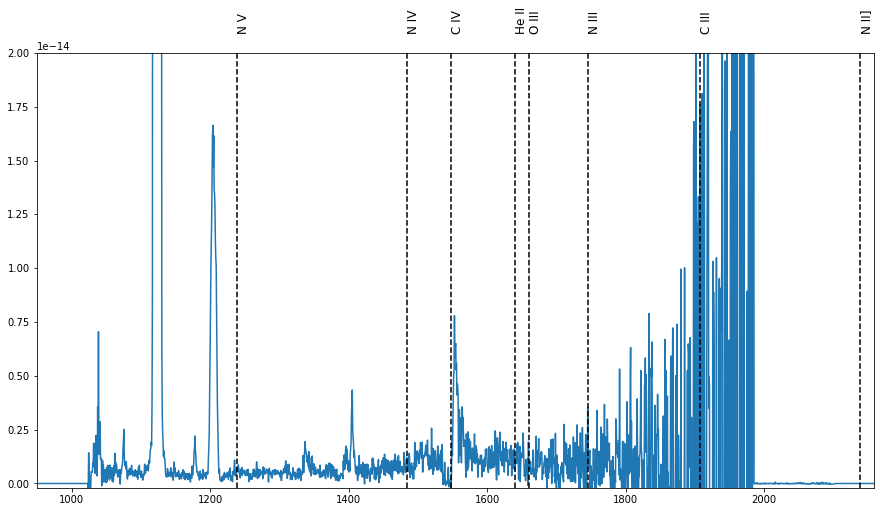

In [141]:
spec = fits.open('./reduced_spectra/2021csp/2021csp_d13FUV.fits')
z = z_dict['2021csp']
ebv = 0.028
a_v = 3.1*ebv

wav = spec[1].data['WAVELENGTH'][0]/(1+z)
flux = spec[1].data['FLUX'][0]

plt.figure(figsize=(15, 8))
bin_size=8
f_bin = np.zeros(int(len(wav)/bin_size))
wav_bin = np.zeros(int(len(wav)/bin_size))
for i in range(int(len(wav)/bin_size)):
    wav_bin[i] = np.average(wav[i*bin_size:i*bin_size+bin_size])
    f_bin[i] = np.sum(flux[i*bin_size:i*bin_size+bin_size])

plt.plot(wav_bin, f_bin)

xcoords=[1238,1484  ,1548  ,1640  ,1660    ,1746   ,1907   ,2139   ,2323   ,2650           , 2795  ]
#xcoords=np.asarray(xcoords)*1.e-4
names=['N V' ,'N IV','C IV','He II','O III','N III','C III','N II]','C II]','Mg II + Fe II','Mg II']
       
for i in range(len(xcoords)):
    if xcoords[i]<max(wav) and xcoords[i]>min(wav):
        plt.axvline(x=xcoords[i],ymax=1,color='black',linestyle='--')
        plt.text(xcoords[i],2.1e-14,names[i],rotation=90,fontsize=12)

plt.ylim(-2e-16, 2e-14)
plt.xlim(min(wav), max(wav))

7.18506660471882e-16
3.115075898313889e-16 5.497192761730391e-16
1.6155533034971257e-15 6.802329698935266e-15
-6.667058991873441e-16 -3.6365776319309675e-15


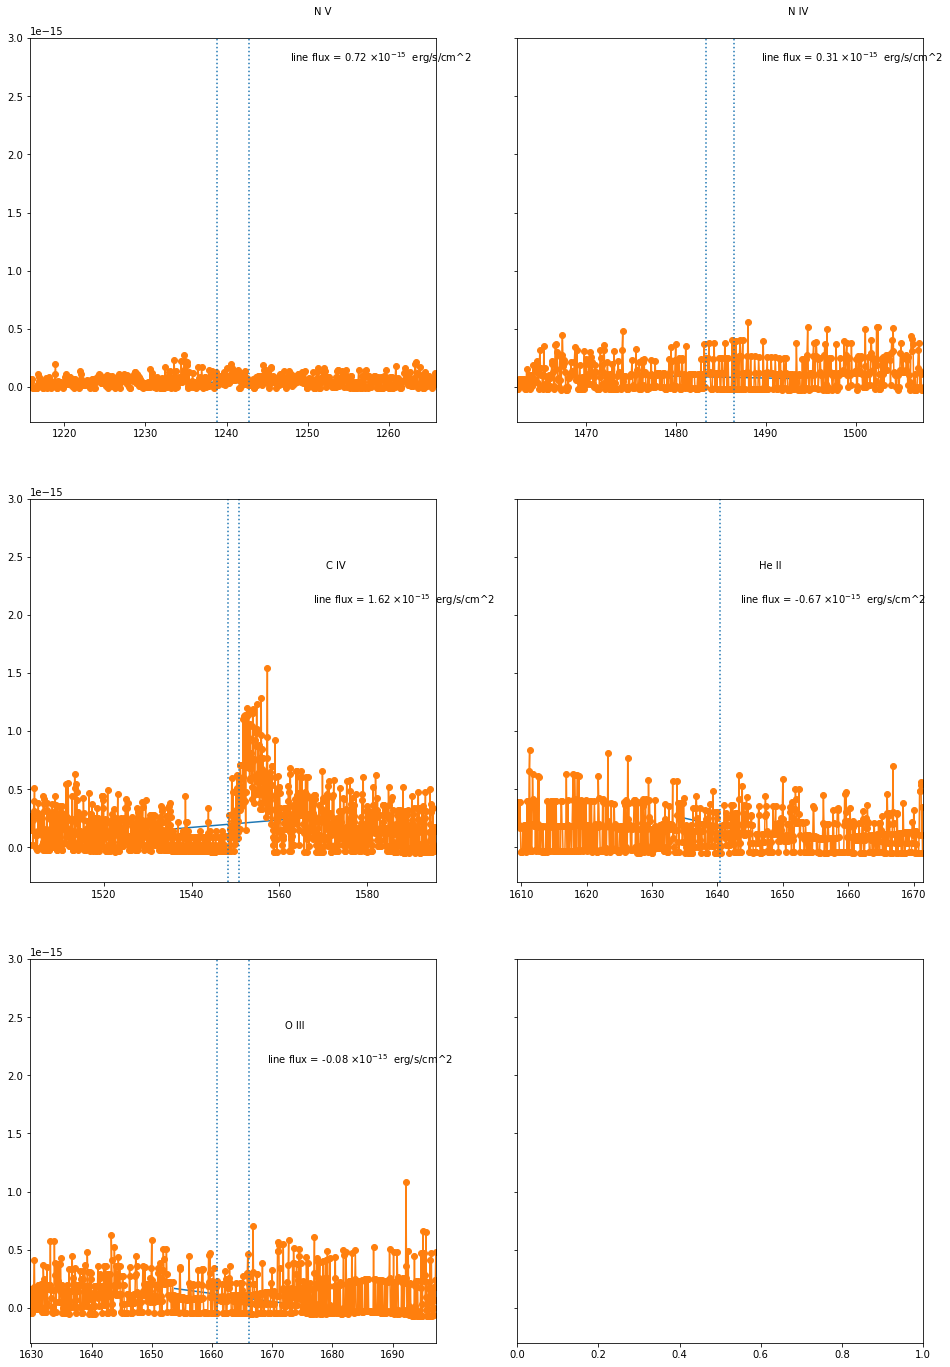

In [142]:
nrows = 3
ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (8*ncols, 8*nrows), sharey = True)

bound = 8
emflux = plot_region(axes[0,0], wav, flux, [1238.8, 1242.8], linename = 'N V', bound = bound, 
                     xlim =15, ylim = 4e-15)
print(emflux)

bound = 6
emflux = plot_region(axes[0,1], wav, flux, [ 1483.3, 1486.5], linename = 'N IV', bound = bound, 
                     xlim =15, ylim = 4e-15)
print(emflux,emflux*4.8/2.72)

bound = 20
emflux = plot_region(axes[1,0], wav, flux, [1548.2, 1550.7], linename = 'C IV', bound = bound, 
                     xlim =25, ylim = 3e-15)
print(emflux,emflux*4.8/1.14)

bound = 6
emflux = plot_region(axes[1,1], wav, flux, [1640.4], linename = 'He II', bound = bound, 
                     xlim =25, ylim = 3e-15)
print(emflux,emflux*4.8/0.88)

bound = 6
emflux = plot_region(axes[2,0], wav, flux, [1660.8, 1666.2], linename = 'O III', bound = bound, 
                     xlim =25, ylim = 3e-15)
#print(emflux*4.8/0.88)

## 2020nxt

(1095.732635981387, 1676.8613420615304)

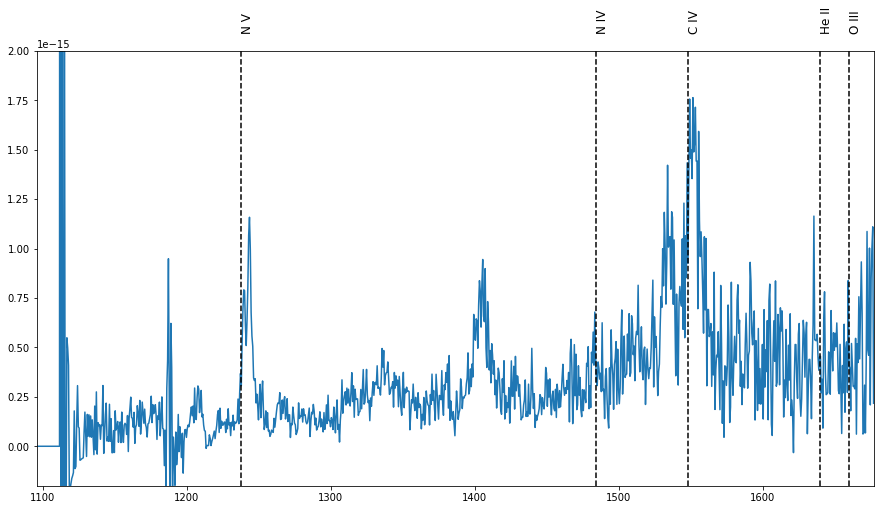

In [148]:
spec = fits.open('./reduced_spectra/2020nxt/2020nxt_d18FUV.fits')
z = z_dict['2020nxt']
ebv = 0.068
a_v = 3.1*ebv

wav = spec[1].data['WAVELENGTH'][0]/(1+z)
flux = spec[1].data['FLUX'][0]

plt.figure(figsize=(15, 8))
if len(wav)>1024:
    bin_size=8
    f_bin = np.zeros(int(len(wav)/bin_size))
    wav_bin = np.zeros(int(len(wav)/bin_size))
    for i in range(int(len(wav)/bin_size)):
        wav_bin[i] = np.average(wav[i*bin_size:i*bin_size+bin_size])
        f_bin[i] = np.sum(flux[i*bin_size:i*bin_size+bin_size])
else:
    plt.plot(wav, flux)

xcoords=[1238,1484  ,1548  ,1640  ,1660    ,1746   ,1907   ,2139   ,2323   ,2650           , 2795  ]
#xcoords=np.asarray(xcoords)*1.e-4
names=['N V' ,'N IV','C IV','He II','O III','N III','C III','N II]','C II]','Mg II + Fe II','Mg II']
       
for i in range(len(xcoords)):
    if xcoords[i]<max(wav) and xcoords[i]>min(wav):
        plt.axvline(x=xcoords[i],ymax=1,color='black',linestyle='--')
        plt.text(xcoords[i],2.1e-15,names[i],rotation=90,fontsize=12)

plt.ylim(-2e-16, 2e-15)
plt.xlim(min(wav), max(wav))

9.352101836142613e-15
1.8000598526832113e-15 3.176576210617431e-15
2.632091237118194e-14 1.1082489419445028e-13
1.7579898807759991e-16 9.589035713323632e-16


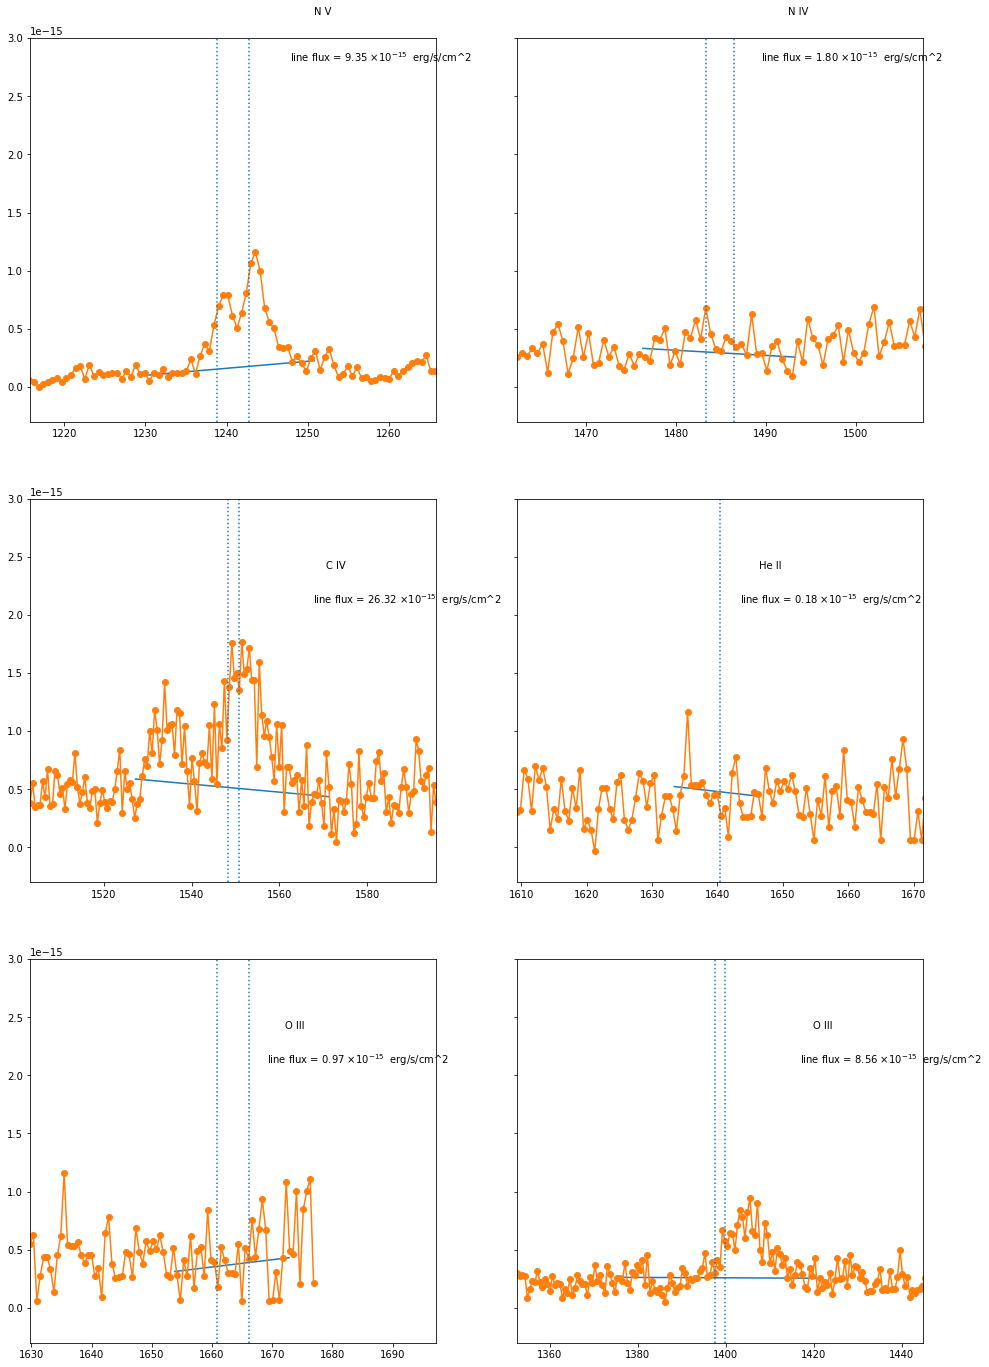

In [152]:
nrows = 3
ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (8*ncols, 8*nrows), sharey = True)

bound = 8
emflux = plot_region(axes[0,0], wav, flux, [1238.8, 1242.8], linename = 'N V', bound = bound, 
                     xlim =15, ylim = 4e-15)
print(emflux)

bound = 6
emflux = plot_region(axes[0,1], wav, flux, [ 1483.3, 1486.5], linename = 'N IV', bound = bound, 
                     xlim =15, ylim = 4e-15)
print(emflux,emflux*4.8/2.72)

bound = 20
emflux = plot_region(axes[1,0], wav, flux, [1548.2, 1550.7], linename = 'C IV', bound = bound, 
                     xlim =25, ylim = 3e-15)
print(emflux,emflux*4.8/1.14)

bound = 6
emflux = plot_region(axes[1,1], wav, flux, [1640.4], linename = 'He II', bound = bound, 
                     xlim =25, ylim = 3e-15)
print(emflux,emflux*4.8/0.88)

bound = 6
emflux = plot_region(axes[2,0], wav, flux, [1660.8, 1666.2], linename = 'O III', bound = bound, 
                     xlim =25, ylim = 3e-15)


bound = 20
emflux = plot_region(axes[2,1], wav, flux, [1397.61, 1399.8], linename = 'O III', bound = bound, 
                     xlim =25, ylim = 3e-15)
#print(emflux*4.8/0.88)

# notes:
#### 2021csp: complicated line structure alike p cygni profile, need to think about how to deal with it
